In [6]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AffinityPropagation
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, \
    completeness_score, silhouette_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
warnings.filterwarnings('ignore')

In [7]:
train = pd.read_csv("train.csv")

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        3169 non-null   int64  
 1   ClientPeriod              3169 non-null   int64  
 2   MonthlySpending           3169 non-null   float64
 3   TotalSpent                3169 non-null   object 
 4   Sex                       3169 non-null   object 
 5   IsSeniorCitizen           3169 non-null   int64  
 6   HasPartner                3169 non-null   object 
 7   HasChild                  3169 non-null   object 
 8   HasPhoneService           3169 non-null   object 
 9   HasMultiplePhoneNumbers   3169 non-null   object 
 10  HasInternetService        3169 non-null   object 
 11  HasOnlineSecurityService  3169 non-null   object 
 12  HasOnlineBackup           3169 non-null   object 
 13  HasDeviceProtection       3169 non-null   object 
 14  HasTechS

## Предварительная обработка

In [9]:
key = "Churn"


 # Определение типов признаков
cat = ["Sex", "HasPartner", "HasChild", "HasPhoneService", 
             "HasMultiplePhoneNumbers", "HasInternetService", 
             "HasOnlineSecurityService", "HasOnlineBackup", 
             "HasDeviceProtection", "HasTechSupportAccess", 
             "HasOnlineTV", "HasMovieSubscription", 
             "HasContractPhone", "IsBillingPaperless", 
             "PaymentMethod", "IsSeniorCitizen"]

num = ["ClientPeriod", "MonthlySpending", "TotalSpent"]

# Предварительная обработка числовых столбцов
for column in num:
    # Заменяем пробелы на NaN и преобразуем в числа
    train[column] = pd.to_numeric(train[column].replace(' ', np.nan), errors='coerce')
    
    # Заполняем пропущенные значения (например, средним)
    mean_val = train[column].mean()
    train[column].fillna(mean_val, inplace=True)

# Удаление столбца id (если есть)
train.drop("id", axis=1, inplace=True, errors='ignore')

# Кодирование категориальных признаков
le = LabelEncoder()
for column in cat:
    train[column] = le.fit_transform(train[column].astype(str))
    train[column] = train[column].astype("category")

# Масштабирование числовых признаков
scaler = MinMaxScaler()
train[num] = scaler.fit_transform(train[num])


train.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ClientPeriod              3169 non-null   float64 
 1   MonthlySpending           3169 non-null   float64 
 2   TotalSpent                3169 non-null   float64 
 3   Sex                       3169 non-null   category
 4   IsSeniorCitizen           3169 non-null   category
 5   HasPartner                3169 non-null   category
 6   HasChild                  3169 non-null   category
 7   HasPhoneService           3169 non-null   category
 8   HasMultiplePhoneNumbers   3169 non-null   category
 9   HasInternetService        3169 non-null   category
 10  HasOnlineSecurityService  3169 non-null   category
 11  HasOnlineBackup           3169 non-null   category
 12  HasDeviceProtection       3169 non-null   category
 13  HasTechSupportAccess      3169 non-null   catego

In [10]:
x, y = train.drop(key, axis=1), train[key]
train

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,0.388889,0.020418,0.054126,1,0,1,1,1,0,2,1,1,1,1,1,1,2,1,1,0
1,0.166667,0.629482,0.103059,1,0,0,0,1,0,1,0,0,0,0,2,0,0,1,2,0
2,0.347222,0.018924,0.059711,1,0,0,0,1,0,2,1,1,1,1,1,1,0,1,3,0
3,0.694444,0.510458,0.392262,1,0,0,0,1,2,0,0,0,2,2,0,2,2,0,0,0
4,0.541667,0.826693,0.453531,0,1,1,0,1,2,1,0,0,0,2,2,2,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3164,0.027778,0.614542,0.017950,1,0,0,0,1,0,1,0,0,0,0,2,0,0,1,2,0
3165,0.222222,0.553785,0.146009,1,0,1,0,1,2,1,0,0,0,0,0,0,0,1,0,1
3166,0.694444,0.518924,0.396462,1,1,0,0,1,2,0,2,2,0,0,2,0,0,1,0,0
3167,0.750000,0.366036,0.354695,1,0,0,1,1,2,0,0,2,0,0,0,0,0,1,1,1


In [11]:
x = pd.get_dummies(x)
imputer = SimpleImputer(strategy='mean')

x = imputer.fit_transform(x)
print(x)

[[0.38888889 0.02041833 0.05412594 ... 1.         0.         0.        ]
 [0.16666667 0.62948207 0.10305912 ... 0.         1.         0.        ]
 [0.34722222 0.0189243  0.05971105 ... 0.         0.         1.        ]
 ...
 [0.69444444 0.5189243  0.39646199 ... 0.         0.         0.        ]
 [0.75       0.36603586 0.35469484 ... 1.         0.         0.        ]
 [0.19444444 0.60358566 0.11826815 ... 0.         1.         0.        ]]


In [12]:
print(y)

0       0
1       0
2       0
3       0
4       0
       ..
3164    0
3165    1
3166    0
3167    1
3168    0
Name: Churn, Length: 3169, dtype: int64


### k-means

In [13]:

cl_count = np.unique(y if isinstance(y, np.ndarray) else y.values).size
kmean = KMeans(n_clusters=cl_count, random_state=7).fit(x)

In [14]:
def plot_graphics(x, y, y_pred=None):
    fig = plt.figure(figsize=(25, 7))
    if y_pred is not None:
        ax3 = fig.add_subplot(1, 3, 3)
        plot_scores(x, y, y_pred, ax3)
    plt.show()

def plot_scores(x, y, y_pred, axis):
    names = ['Adjusted Rand Index', 'Adjusted Mutual Information', 'Homogeneity Score',
        'Completeness Score', 'Accuracy', 'Mistake Rate']
    scores = [adjusted_rand_score(y, y_pred), adjusted_mutual_info_score(y, y_pred), homogeneity_score(y, y_pred),
              completeness_score(y, y_pred), accuracy_score(y, y_pred), 1 - accuracy_score(y, y_pred)]
    axis.bar(names, scores)
    for rect, value in zip(axis.patches, scores):
        axis.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.004,
                     round(value, 3), ha="center")
    axis.set_title("Quality evaluation")
    axis.tick_params("x", labelrotation=90)
    axis.set_xlabel("metric", labelpad=15)
    axis.set_ylabel("eval", labelpad=15)

def visualize_clusters(x, clusters):
    reducer = PCA(n_components=2)
    reduced_features = reducer.fit_transform(x)
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(label='Cluster')
    plt.show()



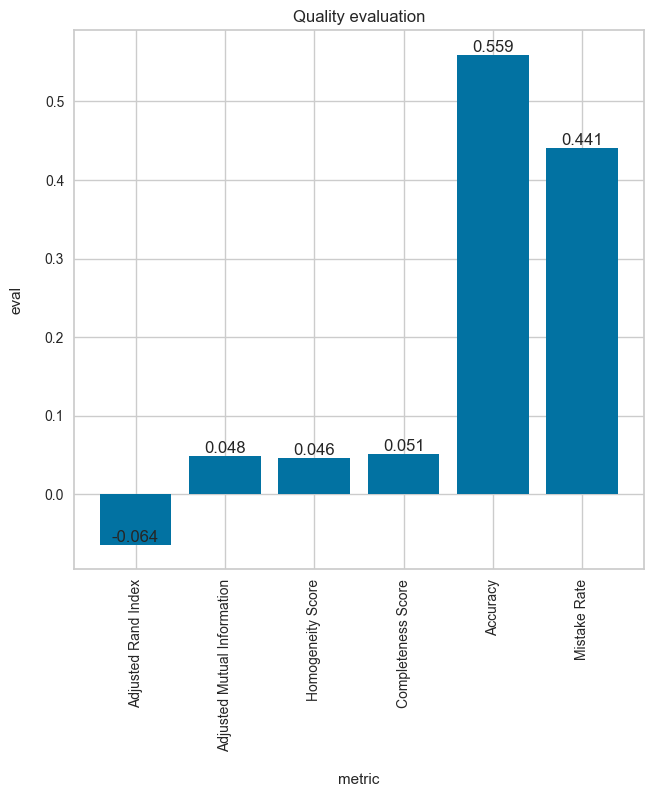

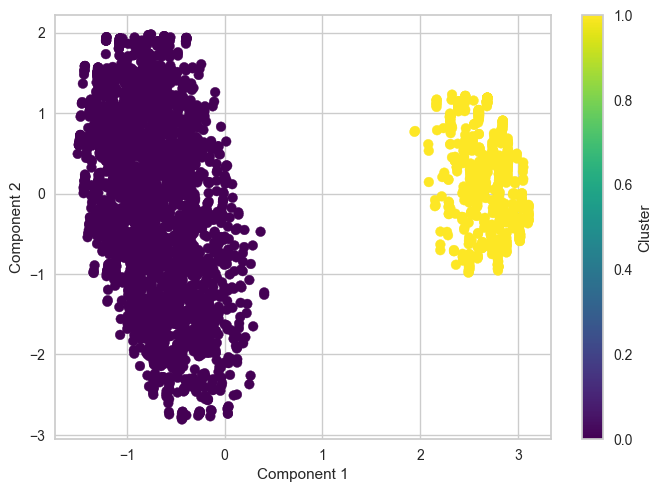

In [15]:
plot_graphics(x, y, y_pred=kmean.labels_)
visualize_clusters(x, clusters=kmean.labels_)

правило локтя

In [16]:
def elbow_rule(x, title="Elbow method"):
    visualizer = KElbowVisualizer(KMeans(random_state=7),
                                  param_grid={"n_clusters": range(1, 600)},
                                  title=title)
    visualizer.fit(x)
    visualizer.show()
    return visualizer.elbow_value_

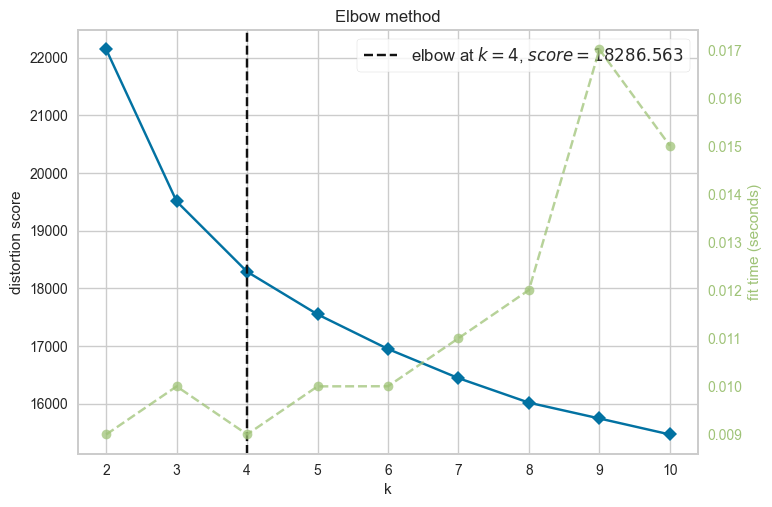

In [17]:
elbow_value = elbow_rule(x)

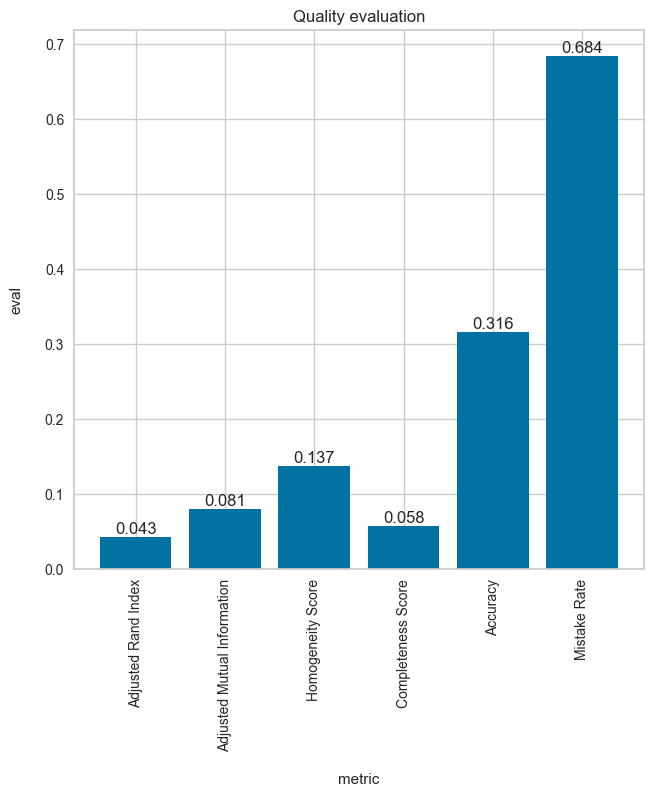

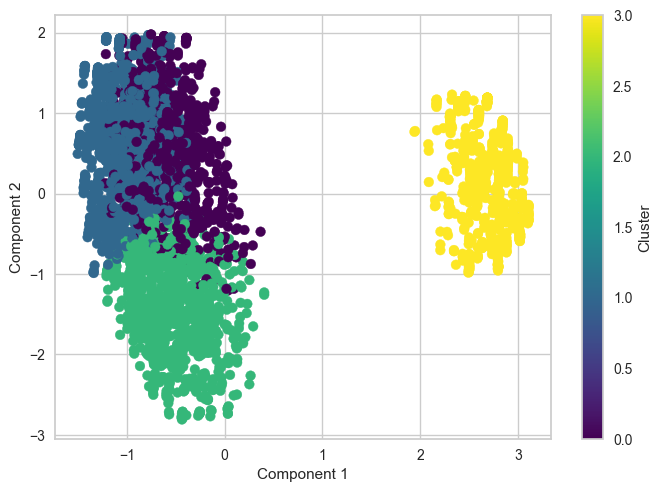

In [18]:
kmean = KMeans(n_clusters=elbow_value, random_state=7).fit(x)
plot_graphics(x, y, kmean.labels_)
visualize_clusters(x, clusters=kmean.labels_)

Affinity Propagation 

In [19]:
def build_af(x, y, param_grid):
    fitted = []
    for params in ParameterGrid(param_grid):
        af = AffinityPropagation(**params, random_state=42).fit(x)
        fitted.append((af, silhouette_score(x, af.labels_)))

    af = max(fitted, key=lambda model: model[1])[0]
    n_clusters = len(af.cluster_centers_indices_)
    plot_graphics(x, y, af.labels_)
    visualize_clusters(x, clusters=af.labels_)
    print(f"Best model params:\n"
          f"damping={af.damping}\n"
          f"max_iter={af.max_iter}\n"
          f"clusters={n_clusters}")

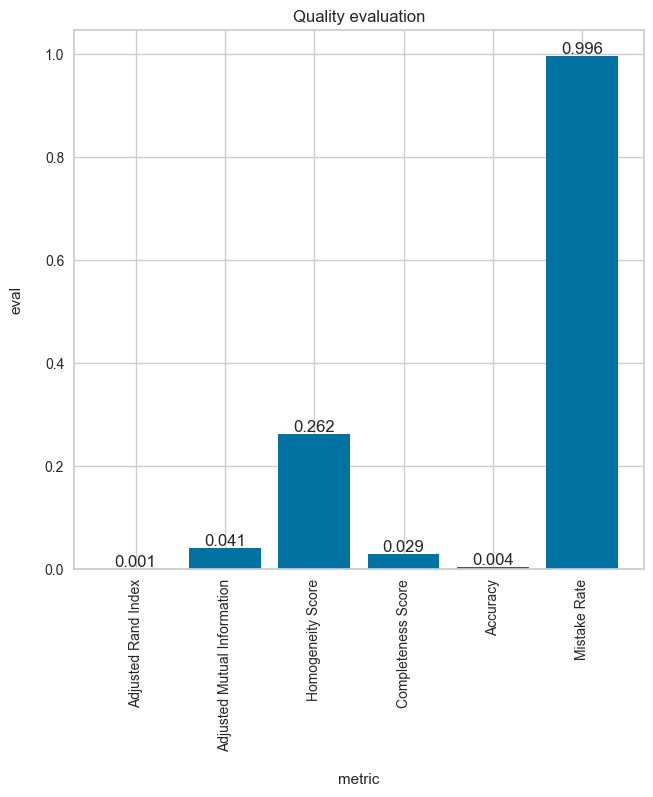

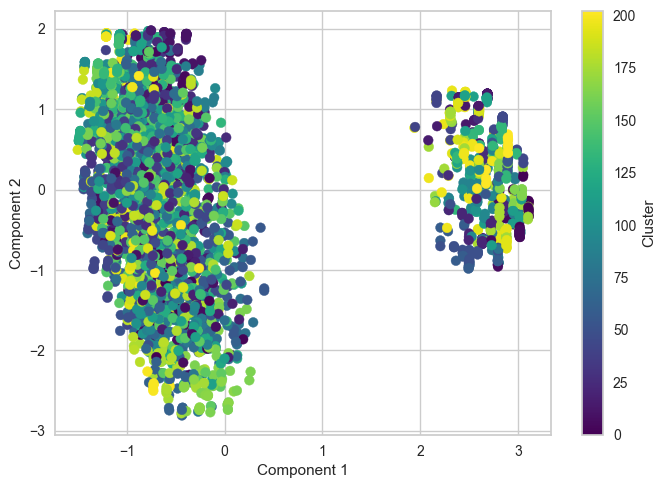

Best model params:
damping=0.8
max_iter=50
clusters=203


In [20]:
param_grid_af = {
        'damping': [0.5, 0.6, 0.7, 0.8, 0.9],
        'max_iter': [50, 100, 200, 500],
    }
build_af(x, y, param_grid_af)